## Problem 1: 
### Anita Mezzetti

See PDF file for details

index:
1. [Complete undirected graph from nodes](#complete)
2. [Conditional independence tests and delete edges](#direct)
    - [Threshold](#threshold)
    - [Partial correlation function (Gaussian)](#partial)
    - [Partial correlation function (Pingouin) (not used)](#partialp)
    - [Remove Edges](#delete)
3. [Orient V-structures](#orient)
    - [Find all undirected v structures](#findv)
    - [Unshielded Colliders function](#unshielded)

4. [Meek rules](#meek)

In [11]:
import numpy as np
from scipy.io import loadmat
import networkx as nx
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from collections import defaultdict
import math
import pingouin as pg
import pandas as pd


import numpy as N, networkx as nx
import sys 
from networkx import DiGraph
from itertools import combinations, permutations, chain
from networkx.algorithms.cycles import find_cycle, simple_cycles
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import itertools 

Define $\alpha$:

In [12]:
alpha = 0.05

Load data and chech size:

In [13]:
data = loadmat("Data.mat")['D']
n = data.shape[0] # sample size
num_nodes = data.shape[1]
data.shape

(10000, 8)

In [14]:
nodes = np.array(range(num_nodes))

### 1. Complete undirected graph from nodes <a name="complete"></a>

I created a function. Then, I discovered that there was a function in Networkx which does the same (_nx.complete_graph(n)_)

In [15]:
# this function create a complete graph (with all possible edges)
def complete_graph(nodes):
    G = nx.Graph()

    G.add_nodes_from(nodes)
    for (i, j) in combinations(nodes, 2):
        G.add_edge(i, j)

    return G

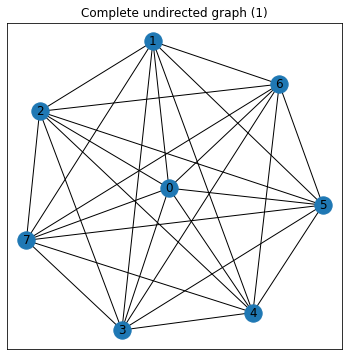

In [16]:
G = complete_graph(nodes) # or nx.complete_graph(nodes)

fig, ax = plt.subplots(figsize=(6, 6))
nx.draw_networkx(G)
plt.title("Complete undirected graph (1)")
plt.show()

## 2. Perform conditional independence tests at a given significance level and delete edges based on the tests <a name="direct"></a>

See all the datails in the PDF

### Threshold
This function finds the threshold:  <a name="threshold"></a> 

In [17]:
def threshold(alpha,n,s):
    if isinstance(s,int):
        #print("s is int")
        abs_s = 1
    else: 
        abs_s = len(s)
    num = norm.ppf(1-alpha/2)
    den = math.sqrt(n-abs_s-3)
    return num/den

### Sample partial correlation

Covariance matrix $\Sigma$ :

In [18]:
cov = np.cov(data.T)
cov.shape

(8, 8)

In [19]:
#check if the covariance matrix is symmetric
(cov.transpose() == cov).all()

True

- This function finds $\Sigma_{X|Y}$ for a multivariate sample and calculate the partial correlation (see PDF): <a name="partial"></a> 

In [20]:
def cond_part_corr_normal(cov,x,y):
    
    # for this algorithm x always has two nodes
    
    if len(x)!=2:
        print("X should contain two nodes")
        return 0

    if not y: # empty
        return abs(cov[x[0], x[1]] / np.sqrt(cov[x[0], x[0]] * cov[x[1], x[1]]))
    
    #conditional cov
    sigma_x = cov[x][:,x]

    if len(y)==1: # if y is a int
        y = int(y[0]) # convert to int
        sigma_y = cov[y][y]
        sigma_xy = cov[x,y].reshape(2,1)
        sigma_yx = cov[y,x]

        cond_cov = sigma_x - sigma_xy * (np.reciprocal(sigma_y)) * sigma_yx

    else: # if y is a list
        y = list(y)
        sigma_y = cov[y][:,y]
        inv_sigma_y = inv(sigma_y)
        sigma_xy = cov[x][:,y]
        sigma_yx = cov[y][:,x]

        cond_cov = sigma_x - sigma_xy @ inv_sigma_y @ sigma_yx # formula in the pdf
  
    aij = cond_cov[0,1]
    aii = cond_cov[0,0]
    ajj = cond_cov[1,1]

    partial_corr = aij / (math.sqrt(abs(aii*ajj)))

    partial_corr = abs(partial_corr)
    
    partial_corr = 0.5* np.log((1+partial_corr)/(1-partial_corr))

    return partial_corr

- Partial correlation suing **pingouin**: <a name="partialp"></a> 

In [21]:
def part_corr_pingouin (data,a,z):
    
    values = [data[: , a[0]]] # shape 10000x1
    values = np.concatenate((values, [data[: , a[1]]])) 
    values = np.concatenate((values, [data[: , z[0]]])) 
    
    # we have to use these names to make it work
    name = ["x","y",str(z[0])]
    
    if len(z)>1:
        for i in z[1:]:
            values = np.concatenate((values, [data[: , i]])) 
            name =  np.concatenate((name, [str(i)] ))

    df = pd.DataFrame(values.T, columns=name)
 
    result = df.pcorr()

    return abs(result.y.x)

### Remove edges 
In the nex cell we remove edges from the completed undirected graph: <a name="delete"></a>

In [22]:
def remove_edges(nodes,cov):
    
    G = complete_graph(nodes)
    S = defaultdict(set)
    l = 0
    loop_cond = True
    nodes = G.nodes()

    while loop_cond:
        
        loop_cond = False
        
        for i, j in permutations(nodes, 2):  # for each edge 

            neigh_i = set(complete_graph(nodes).neighbors(i))

            if not (j in neigh_i and len(neigh_i - {j}) >= l):  # that are adjacent and |adj(G,i)\{j}| >= l
                continue

            neigh_i_not_j = neigh_i - {j}

            for k in combinations(neigh_i_not_j, l):  # choose k \subset adj(G, i) - {j} with |k| = l

                partial_corr = cond_part_corr_normal (cov, [i,j] , k)
                t = threshold(alpha,n, [k])

                if partial_corr<t: # i ind j | k
                    S[(i, j)] = S[(i, j)] | set(k)
                    S[(j, i)] = S[(j, i)] | set(k)
                    if G.has_edge(i, j):
                        print(f"Remove {i,j} | {k}")
                        G.remove_edge(i, j)
                    break

            loop_cond = True  # There were some k s.t. |k| > l
        l += 1
    return G, S

In [23]:
partial_corr = cond_part_corr_normal (cov, [3,6] , [0, 1, 4, 7])
t = threshold(alpha,n, [0, 1, 4, 7])

partial_corr,t

(0.01791869975853449, 0.019606503322882374)

In [24]:
G,S = remove_edges(nodes,cov)

Remove (0, 1) | ()
Remove (0, 1) | () : partial_corr:0.0002170749629688407 t:0.01960356094974014
Remove (1, 0) | ()
Remove (1, 2) | ()
Remove (1, 2) | () : partial_corr:0.0014608955105152172 t:0.01960356094974014
Remove (1, 3) | ()
Remove (1, 3) | () : partial_corr:0.01312989871385623 t:0.01960356094974014
Remove (1, 4) | ()
Remove (1, 4) | () : partial_corr:0.0037363713516547093 t:0.01960356094974014
Remove (1, 5) | ()
Remove (1, 5) | () : partial_corr:0.002426094159300246 t:0.01960356094974014
Remove (1, 7) | ()
Remove (1, 7) | () : partial_corr:0.002906184797217224 t:0.01960356094974014
Remove (2, 1) | ()
Remove (3, 1) | ()
Remove (4, 1) | ()
Remove (5, 1) | ()
Remove (7, 1) | ()
Remove (0, 1) | (2,)
Remove (0, 3) | (2,)
Remove (0, 3) | (2,) : partial_corr:0.015139517669008866 t:0.01960356094974014
Remove (0, 6) | (4,)
Remove (0, 6) | (4,) : partial_corr:0.006629856543928722 t:0.01960356094974014
Remove (1, 0) | (2,)
Remove (1, 2) | (0,)
Remove (1, 3) | (0,)
Remove (1, 4) | (0,)
Rem

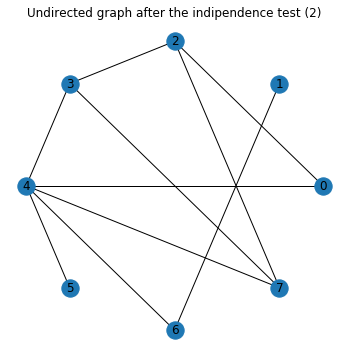

In [25]:
# plot skeleton:

fig, ax = plt.subplots(figsize=(6, 6))

if nx.check_planarity(G, counterexample=False)[0]==True: # if planar
    pos = nx.circular_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
else: # if not planar
    pos = nx.draw_networkx(G)
    
plt.title("Undirected graph after the indipendence test (2)")
plt.show()

### 3. Orient V-structures <a name="orient"></a>

**Statistical orientation**:  <a name="stat"></a>
Function to find unshielded colliders and create edges:

In [26]:
def statistical_orientation(G, S):

    di_G = G.to_directed() # completely directed graph

    for i, j in combinations(di_G.nodes() , 2):  # for all couples i,j

        # a successor of n is a node m such that there exists a directed edge from n to m
        adj_i = set(di_G.successors(i))
        adj_j = set(di_G.successors(j))

        if j in adj_i or i in adj_j:
            continue  # that are nonadjacent (i.e no edge i-j)

        for k in (adj_i & adj_j):  # with common neighbour k
            if k not in S[(i, j)]:
                print(f"v-struct {i} -> {k} <- {j}")
                di_G.remove_edges_from([(k, i), (k, j)])  # replace i <-> k <-> j by i -> k <- j

    return di_G

In [27]:
di_G = statistical_orientation(G, S)

v-struct 0 -> 4 <- 3
v-struct 1 -> 6 <- 4
v-struct 2 -> 7 <- 4


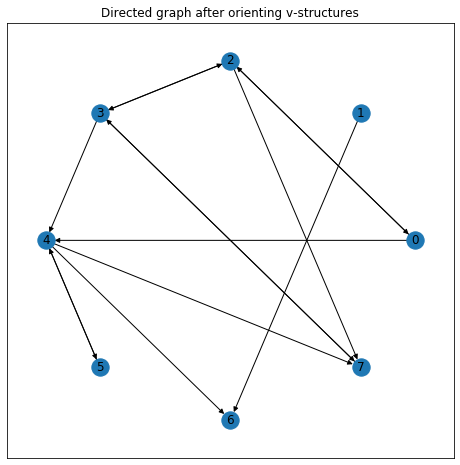

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx(di_G, pos = pos)
plt.title("Directed graph after orienting v-structures")
plt.show()

### Meek Rules <a name="meek"></a>

In [29]:
def not_directed(edge,di_G): # check if a<->b return True
    a = edge[0]
    b = edge[1]
    
    if (a,b) in di_G.edges and (b,a) in di_G.edges:
        return True
    return False

In [30]:
def is_directed(edge,di_G): # check if a->b return True
    a = edge[0]
    b = edge[1]
    
    if (a,b) in di_G.edges and (b,a) not in di_G.edges:
        return True
    return False

In [31]:
def no_edge(a,b,di_G): # check if no edge a-b return True
    if (a,b) not in di_G.edges and (b,a) not in di_G.edges:
        return True
    return False

Check if the edge a-b is already directed:

In [32]:
def meek_rule_1(edge, G, di_G):
    
    if not_directed(edge,di_G)==False: # already directed
        return 0
    
    a = edge[0]
    b = edge[1]

    # list of possible c
    neghs_a = set(G.neighbors(a)) - {b} # neigbours of a

    # c if exists c->a
    c_linked_a = [c for c in neghs_a if is_directed([c,a],di_G)]
    # c cannot be linked to b in G
    c = [c for c in c_linked_a if no_edge(c,b,di_G)]
    
    # if c is not empty
    if len(c)>0:
        di_G.remove_edge(b,a) # from a<->b to a->b
        print(f"Meek1 {a}->{b}: exist {c[0]} such that {c[0]}->{a} and ({c[0]},{b}) not in G")
        return 1
    
    return 0

In [33]:
def meek_rule_2(edge, G, di_G):
    
    if not_directed(edge,di_G)==False: # already directed
        return 0
    
    a = edge[0]
    b = edge[1]
    
    # list of possible c
    neghs_a = set(G.neighbors(a)) - {b} # neigbours of a
    
    # c if exists a->c
    c_linked_a = [c for c in neghs_a if is_directed([a,c],di_G)]
    
    # c if exist c->b
    c = [c for c in c_linked_a if is_directed([c,b],di_G)]
    
    # if c is not empty
    if len(c)>0:
        di_G.remove_edge(b,a) # from a<->b to a->b
        print(f"Meek2 {a}->{b}: exist {c[0]} such that {a}->{c[0]} and {c[0]}->{b} (avoid cycle)")
        return 1
    
    return 0

In [34]:
def meek_rule_3(edge, G, di_G):
    
    if not_directed(edge,di_G)==False: # already directed
        return 0
    
    a = edge[0]
    b = edge[1]

    # list of possible c or d
    neghs_a = set(G.neighbors(a)) - {b} # neigbours of a
    
    # c(d) if exist c(b)->b
    c_or_d = [c for c in neghs_a if is_directed([c,b],di_G)]
    
    flag = 0
    for c in c_or_d:
        
        possible_d = c_or_d.remove(c)
        
        if possible_d is not None:
            # c not linked to d
            d = [d for d in possible_d if no_edge(c,d,di_G)]

            if len(d)>0: # we have found at least one d
                flag=1
                break

    
    if flag==1:
        di_G.remove_edge(b,a) # from a<->b to a->b
        print(f"Meek3 {a}->{b}: exist {c},{d[0]} such that {a}-{c}, {a}-{d[0]}, {c}->{b}, {d[0]}->{b} and ({c},{d[0]}) not in G")
        return 1
    
    return 0

In [35]:
def meek_rule_4(edge, G, di_G):
    
    if not_directed(edge,di_G)==False: # already directed
        return 0
    
    a = edge[0]
    b = edge[1]
    
    # list of possible c or d
    neghs_a = set(G.neighbors(a)) - {b} # neigbours of a
    
    # c if exist c->b
    c_list = [c for c in neghs_a if is_directed([c,b],di_G)]
    
    flag = 0
    for c in c_list:
        
        # d if d-a and d->c
        possible_d = [d for d in neghs_a-{c} if is_directed([d,c],di_G)]
            
        if possible_d is not None:

            # d not linked to b
            possible_d = [ d for d in possible_d if no_edge(d,b,di_G)]

            if possible_d is not None:
                # d->c
                d = [d for d in possible_d if (d,c) in di_G.edges]

                if len(d)>0: # we have found at least one d
                    flag=1
                    break

    
    if flag==1:
        di_G.remove_edge(b,a) # from a<->b to a->b
        print(f"Meek4 {a}->{b}: exist {c},{d[0]} such that {a}-{c}, {a}-{d[0]}, {c}->{b}, {d[0]}->{c} and ({b},{d[0]}) not in G")
        return 1
    
    return 0

Function which find all unidrected edges:

In [36]:
def meek_rules(G, di_G):
    
    flag = 0 

    while flag == 0: # continue till you don't add any other edges
        
        flag = 1 # it will become 1 if we'll add other edges

        for edge in di_G.edges(): # for each edge

            if not_directed(edge,di_G): # if not directed

                # try to orient 
                a = edge[0]
                b = edge[1]

                meek1= meek_rule_1(edge, G, di_G)
                meek2= meek_rule_2(edge, G, di_G)
                meek3= meek_rule_3(edge, G, di_G)
                meek4= meek_rule_4(edge, G, di_G)

                # if we have added atr least one edge we have to re-check everything
                if meek1==1 or meek2==1 or meek3==1 or meek4==1:
                    flag = 0
            
    return di_G

In [37]:
di_G = meek_rules(G,di_G)

Meek2 3->7: exist 4 such that 3->4 and 4->7 (avoid cycle)
Meek1 4->5: exist 0 such that 0->4 and (0,5) not in G


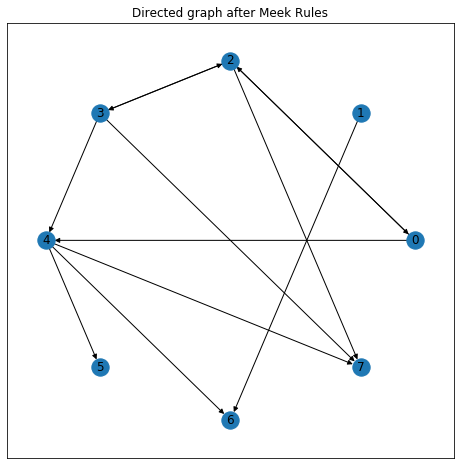

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx(di_G, pos = pos)
plt.title("Directed graph after Meek Rules")
plt.show()

### Equivalence classes <a name="equivalence"></a>

In [39]:
# check if we have a dag between the directed eges
def is_dag(di_G):

    directed = [edge for edge in di_G.edges() if not_directed(edge,di_G)==False]
    di_G_un = nx.DiGraph()
    di_G_un.add_edges_from(di_G_un)

    try:
        find_cycle(di_G_un)
    except:
        # print("No cycles (GOOD)")
        return True

Firstly, we find all the undirected edges. They are the edges which are in G and not in di_G

In [40]:
def undirected_edges(G,di_G):
    
    undirected = []

    for edge in G.edges():
        if not_directed(edge,di_G): # not directed
            undirected.append(edge)
    
    return undirected

In [41]:
undirected_edges(G,di_G)

[(0, 2), (2, 3)]

In [42]:
len(undirected_edges(G,di_G))

2

At this point we can think that, for each undirected edge we have two opportunity (one direction and the other). So if we have $n$ undirected edges, one can think that $2^n$ is the answer.

However, if we have more than one undirected edge, if we direct one, this can direct also the others. For example, if we have two undirected edges, it can happen that if we direct one, the other one has to be directed in order to avoid cycles.

This function return how many DAGs are in the corresponding equivalence class 

In [43]:
def equivalence_classes(equi_classes, G, di_G):
    
    undirected = undirected_edges(G,di_G)
    directed = [edge for edge in di_G.edges() if not_directed(edge,di_G)==False]
    
    if len(undirected)==0: # all already directed
        print("a")
        print("All edges are already directed")
        print(di_G)
        return [di_G]

    
    equi_classes = []
    
    print(f"\n--------------------------\nUnidrected edge: {undirected}\n")
    
    if len(undirected)==1: # only one undirected edge
        
        print("Only one undirected edge")
        
        # we are sure not to create unshielded colliders or cycles, otherwise we would have detected it before
        
        #return 2
        G1 = nx.DiGraph()
        G2 = nx.DiGraph()
        
        G1.add_edges_from(di_G.edges)
        G2.add_edges_from(di_G.edges)
        
        G1.remove_edge(undirected[0][1],undirected[0][0])
        G2.remove_edge(undirected[0][0],undirected[0][1])
        
        equi_classes.append(G1)
        equi_classes.append(G2)
        
        return equi_classes
        
    elif len(undirected)>1: # more than one
        
        # equivalent graph
        equivalent_G = nx.DiGraph()
        equivalent_G.add_edges_from(di_G.edges())
        
        #### we try to add one edge in one direction
        added_edge = undirected[0]
        print(f"ADD EDGE: {added_edge}")
        
        equivalent_G.remove_edge(added_edge[1], added_edge[0]) # add 0->1
        
        # now we check if other edges are still undirected or if we can direct some:    
        
        print("\nMeek Rules:")
        meek_rules(G, equivalent_G)

        # at this point we can have all directed, or no new directed, or some of them directed
        
        if not undirected_edges(G,equivalent_G) and is_dag(equivalent_G) == True: # all directed and it is a DAG
            print(f"\nAdding {added_edge}, all directed \n")
 
            # we added one edge and this directed all the others. we add this final configuration
            equi_classes.append(equivalent_G)
            
        elif is_dag(equivalent_G) == True: # some not directed but it is a DAG
            # recall the function
            new = equivalence_classes(equi_classes,G,equivalent_G)
       
            for graph in new:
                equi_classes.append(graph)
            
            
        #else: it is not a DAG and therefore this edge cannot be added

        #### we try to add one edge in the other direction
        equivalent_G1 = nx.DiGraph()
        equivalent_G1.add_edges_from(di_G.edges())
        
        print(f"\n\nADD EDGE: {added_edge[1],added_edge[0]}")
        
        equivalent_G1.remove_edge(added_edge[0], added_edge[1]) # add 1->0
        
        # now we check if other edges are still undirected or if we can direct some:
        
        print("\nMeek Rules:")
        meek_rules(G, equivalent_G)

        if not undirected_edges(G,equivalent_G1) and is_dag(equivalent_G1) == True: # all directed and it is a DAG
            print(f"\nAdding {added_edge[1],added_edge[1]}, all directed \n")
            # we added one edge and this directed all the others. we add this final configuration
            equi_classes.append(equivalent_G1)
            
        elif is_dag(equivalent_G1) == True: # some not directed but it is a DAG
            # recall the function
            new = equivalence_classes(equi_classes,G,equivalent_G1)

            for graph in new:
                equi_classes.append(graph)
            
         #else: it is not a DAG and therefore this edge cannot be added
        
    # drop duplicates
    if len(equi_classes)==1: # no duplicates
        return equi_classes
    
    
    equi_classes_unique = []
    for G1 in equi_classes:
        for G2 in equi_classes:

            if nx.is_isomorphic(G1,G2): #equal
                equi_classes_unique.append(G2)
                equi_classes = [x if x is not G2 else nx.DiGraph() for x in equi_classes] # substitude all the other occurence in order not having more      
                break

    return equi_classes_unique

In [44]:
equi_classes = []
equi_classes = equivalence_classes(equi_classes, G, di_G)


--------------------------
Unidrected edge: [(0, 2), (2, 3)]

ADD EDGE: (0, 2)

Meek Rules:
Meek1 2->3: exist 0 such that 0->2 and (0,3) not in G

Adding (0, 2), all directed 



ADD EDGE: (2, 0)

Meek Rules:

--------------------------
Unidrected edge: [(2, 3)]

Only one undirected edge


In [45]:
def num_equivalence_class(equi_classes):    
    return len(equi_classes)

We have found the number of equivalent classes

In [46]:
num = num_equivalence_class(equi_classes)
num

3

### Plot equivalent classes

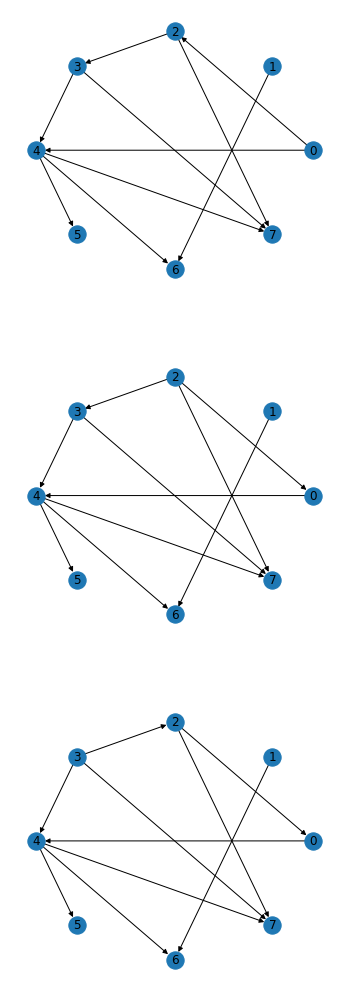

In [47]:
if num>1:
    fig, axes = plt.subplots(nrows=num, ncols=1, figsize = ( 6 , num*6))
    ax = axes.flatten()
    for i in range(num):
        nx.draw_networkx(equi_classes[i], pos = pos, ax=ax[i])
        ax[i].set_axis_off()

    plt.show()
else:
    fig, axes = plt.subplots(figsize = ( 6 , num*6))
    nx.draw_networkx(equi_classes[i], pos = pos)